In [39]:
import os
import json
import time
import threading

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor

In [28]:
sample_video = {
    "positions": {
        "1.0": {
            "Nose": [1, 1, 1],
            "Left_eye": [1, 1, 1],
        },
        "2.0": {
            "Nose": [2, 2, 2],
            "Left_eye": [2, 2, 2],
        },
        "3.0": {
            "Nose": [3, 3, 3],
            "Left_eye": [3, 3, 3],
        },
        "4.0": {
            "Nose": [4, 4, 4],
            "Left_eye": [4, 4, 4],
        },
    }
}

sample_video["positions"]["1.0"]["Nose"]

[1, 1, 1]

  <!-- for column in row.index:
            # Extract joint name and position (e.g., Nose_x)
            joint = '_'.join(column.split('_')[1:])
            if joint not in mean_data_series:
                mean_data_series[joint] = []
            mean_data_series[joint].append(row[column]) -->

Let say we have
a[1_a_x:5, 1_a_y:4, 2_a_x:3, 2_a_y:7]
The above code give:
result = {
a_x:[5,3],
a_y:[4,7]
}


In [29]:
def getFilesPath(directory):
    files = []
    for root, dirs, file in os.walk(directory):
        for f in file:
            files.append(os.path.join(root, f))
    return files


def loadFiles(files_path, activities, joints_mapping, target_frames=30):
    """
    Load and process activity data files.

    This function loads JSON files containing activity data, resamples the data to a target number of frames,
    flattens the data, and combines it into a single DataFrame. The function filters files based on the specified
    activities and processes only those files.

    Parameters:
    - files_path (list of str): List of file paths to be processed.
    - activities (list of str): List of activity names to filter the files.
    - joints_mapping (list): Dictionary mapping joint names to their indices.
    - target_frames (int, optional): The target number of frames to resample the data to. Default is 30.

    Returns:
    - pd.DataFrame: A DataFrame containing the processed and combined activity data. If no data is processed, 
    an empty DataFrame is returned.
    """
    activity_dfs = []
    for activity in activities:
        for file_path in files_path:
            if file_path.endswith('.json') and activity in file_path:
                with open(file_path, 'r') as file:
                    file_data = json.load(file)
                    resample_file_data = resample_video(file_data, joints_mapping, target_frames)
                    if resample_file_data is None:
                        continue
                    file_df = flatternData(resample_file_data, joints_mapping)
                    file_df.insert(0, 'Group', file_path.split('\\')[-1].split('-')[0])
                    file_df.insert(1, 'Activity', activity)
                    activity_dfs.append(file_df)

    if activity_dfs:
        final_df = pd.concat(activity_dfs, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()


def flatternData(data, joints_mapping):
    # Create a list of dictionaries for each timestamp and joint
    flattened_data = [
        {f'{timestamp}_{joint}_{axis}': position[joint][i]
            for joint in joints_mapping if joint in position
            for i, axis in enumerate(['x', 'y', 'z'])}
        for timestamp, position in data.items()
    ]

    # Flatten the list of dictionaries into a single dictionary
    flattened_data = {k: v for d in flattened_data for k, v in d.items()}
    return pd.DataFrame([flattened_data])


def resample_video(video_data, joint_mapping, target_frames=30):
    # Get the original frame numbers and convert to float
    original_frames = np.array([float(k) for k in video_data['positions'].keys()])
    # check that video has at least 4 frames

    if len(original_frames) < 50:
        return None
    # Create new evenly spaced frames
    new_frames = np.linspace(min(original_frames), max(original_frames), target_frames)

    # Get all unique joints
    joints = list(next(iter(video_data['positions'].values())).keys())

    # Initialize the resampled data structure
    resampled_data = {str(float(i)): {} for i in range(1, target_frames + 1)}

    # Interpolate each joint's coordinates
    for joint in joint_mapping:
        # Extract x, y, z coordinates for the current joint across all frames
        coords = np.array([video_data['positions'][str(frame)][joint] for frame in original_frames])
        x_coords, y_coords, z_coords = coords[:, 0], coords[:, 1], coords[:, 2]

        # Create cubic interpolation functions for each coordinate
        x_interp = interp1d(original_frames, x_coords, kind='cubic')
        y_interp = interp1d(original_frames, y_coords, kind='cubic')
        z_interp = interp1d(original_frames, z_coords, kind='cubic')

        # Apply interpolation to get new coordinates
        for i, frame in enumerate(new_frames, 1):  # Start counting from 1
            resampled_data[str(float(i))][joint] = [
                float(x_interp(frame)),
                float(y_interp(frame)),
                float(z_interp(frame))
            ]
    return resampled_data


def calculateFeatureForAllVideos(df):
    # Store the group and activity columns
    labed_df = df[['Group', 'Activity']]

    # Ignore the group and activity columns for calculation
    df = df.drop(columns=['Group', 'Activity'])

    # Extract joint names and coordinates
    joint_names = df.columns.str.split('_').str[1:].str.join('_')

    # Calculate statistics for each joint
    mean_df = df.T.groupby(joint_names).mean().T
    median_df = df.T.groupby(joint_names).median().T
    std_df = df.T.groupby(joint_names).std().T
    var_df = df.T.groupby(joint_names).var().T
    min_df = df.T.groupby(joint_names).min().T
    max_df = df.T.groupby(joint_names).max().T
    range_df = max_df - min_df

    # Combine all statistics into a single DataFrame
    stats_df = pd.concat([mean_df, median_df, std_df, var_df, min_df, max_df, range_df], axis=1)
    stats_df.columns = [f'{col}_mean' for col in mean_df.columns] + \
                       [f'{col}_median' for col in median_df.columns] + \
                       [f'{col}_std' for col in std_df.columns] + \
                       [f'{col}_var' for col in var_df.columns] + \
                       [f'{col}_min' for col in min_df.columns] + \
                       [f'{col}_max' for col in max_df.columns] + \
                       [f'{col}_range' for col in range_df.columns]

    # Add back the group and activity columns
    stats_df.insert(0, 'Group', labed_df['Group'])
    stats_df.insert(1, 'Activity', labed_df['Activity'])

    return stats_df


def group_by_activity(dfs, onehot_columns):
    # Concatenate all DataFrames in the list
    merged_df = pd.concat(dfs, ignore_index=True)
    # Onehot the onehot_columns
    merged_df = pd.get_dummies(merged_df, columns=onehot_columns)
    return merged_df

In [30]:
# List of joint names in OpenPose
openpose_joint_mapping = [
    "Nose",
    "Left_eye",
    "Right_eye",
    "Left_ear",
    "Right_ear",
    "Left_shoulder",
    "Right_shoulder",
    "Left_elbow",
    "Right_elbow",
    "Left_wrist",
    "Right_wrist",
    "Left_hip",
    "Right_hip",
    "Left_knee",
    "Right_knee",
    "Left_ankle",
    "Right_ankle"
]

In [31]:
# path to data
root_path = os.getcwd()
group1A_path = os.path.join(root_path, 'Group1A', 'blazepose')
group2A_path = os.path.join(root_path, 'Group2A', 'blazepose')
group3_path = os.path.join(root_path, 'Group3', 'blazepose')

group1B_path = os.path.join(root_path, 'Group1B', 'blazepose')
group2B_path = os.path.join(root_path, 'Group2B', 'blazepose')

# activities
activities = ['CTK', 'ELK', 'RTK']
# activities = ['ELK']

# Get paths
group1A_files_path = getFilesPath(group1A_path)
group2A_files_path = getFilesPath(group2A_path)
group3_files_path = getFilesPath(group3_path)

group1B_files_path = getFilesPath(group1B_path)
group2B_files_path = getFilesPath(group2B_path)

In [32]:
def countFrames(files_path, activities):
    """
    Count the number of frames for each video file and return details.

    This function loads JSON files containing activity data and counts the number of frames in each file.
    The function filters files based on the specified activities and processes only those files.

    Parameters:
    - files_path (list of str): List of file paths to be processed.
    - activities (list of str): List of activity names to filter the files.

    Returns:
    - pd.DataFrame: A DataFrame with columns 'Group', 'Activity', 'VideoName', and 'FrameCount'.
    """
    frame_counts = []
    for activity in activities:
        for file_path in files_path:
            if file_path.endswith('.json') and activity in file_path:
                with open(file_path, 'r') as file:
                    file_data = json.load(file)
                    frame_count = len(file_data['positions'])  # Assuming 'frames' is the key for frame data
                    group = file_path.split('\\')[-1].split('-')[0]
                    video_name = file_path.split('\\')[-1]
                    frame_counts.append({
                        'Group': group,
                        'Activity': activity,
                        'VideoName': video_name,
                        'FrameCount': frame_count
                    })
    return pd.DataFrame(frame_counts)

In [34]:
# Example usage
frame_counts_group1A = countFrames(group1A_files_path, activities)
frame_counts_group2A = countFrames(group2A_files_path, activities)
frame_counts_group3 = countFrames(group3_files_path, activities)
frame_counts_group1B = countFrames(group1B_files_path, activities)
frame_counts_group2B = countFrames(group2B_files_path, activities)

# merge all frame counts
frame_counts = pd.concat([frame_counts_group1A, frame_counts_group2A, frame_counts_group3,
                         frame_counts_group1B, frame_counts_group2B], ignore_index=True)
frame_counts
# export to csv
frame_counts.to_csv('frame_counts.csv', index=False)

In [64]:
# Load data
group1A_df = loadFiles(group1A_files_path, activities, openpose_joint_mapping, 200)
group2A_df = loadFiles(group2A_files_path, activities, openpose_joint_mapping, 200)
group3_df = loadFiles(group3_files_path, activities, openpose_joint_mapping, 200)

group1B_df = loadFiles(group1B_files_path, activities, openpose_joint_mapping, 200)
group2B_df = loadFiles(group2B_files_path, activities, openpose_joint_mapping, 200)

# Store data to csv
group1A_df.to_csv('group1A.csv', index=False)
group2A_df.to_csv('group2A.csv', index=False)
group3_df.to_csv('group3.csv', index=False)

group1B_df.to_csv('group1B.csv', index=False)
group2B_df.to_csv('group2B.csv', index=False)

In [42]:
# Load data from csv
group1A_df = pd.read_csv('group1A.csv')
group2A_df = pd.read_csv('group2A.csv')
group3_df = pd.read_csv('group3.csv')
group1B_df = pd.read_csv('group1B.csv')
group2B_df = pd.read_csv('group2B.csv')
group2A_df.head(10)

,Group,Activity,1.0_Nose_x,1.0_Nose_y,1.0_Nose_z,1.0_Left_eye_x,1.0_Left_eye_y,1.0_Left_eye_z,1.0_Right_eye_x,1.0_Right_eye_y,...,200.0_Left_knee_z,200.0_Right_knee_x,200.0_Right_knee_y,200.0_Right_knee_z,200.0_Left_ankle_x,200.0_Left_ankle_y,200.0_Left_ankle_z,200.0_Right_ankle_x,200.0_Right_ankle_y,200.0_Right_ankle_z
0,G2A,CTK,0.539282,0.431655,-0.384252,0.543288,0.422329,-0.375004,0.535076,0.421193,...,-0.014480,0.493701,0.693743,0.007707,0.566503,0.806848,0.067230,0.491475,0.797624,0.094346
1,G2A,CTK,0.536172,0.423099,-0.371713,0.541568,0.413143,-0.360224,0.530744,0.413438,...,-0.044134,0.491112,0.689791,0.004020,0.569369,0.802822,0.067648,0.490229,0.793349,0.112206
2,G2A,CTK,0.535749,0.426137,-0.329033,0.540784,0.416252,-0.318657,0.530550,0.415722,...,-0.037581,0.490429,0.689368,-0.010226,0.568471,0.809388,0.062584,0.490325,0.791414,0.098893
3,G2A,CTK,0.532929,0.422983,-0.337072,0.538118,0.412713,-0.325379,0.527363,0.413857,...,-0.067654,0.494635,0.685256,-0.012694,0.568036,0.802359,0.037574,0.493075,0.788239,0.085044
4,G2A,CTK,0.533912,0.434876,-0.376311,0.540084,0.424898,-0.366900,0.528902,0.424295,...,-0.071643,0.491005,0.683609,-0.053144,0.569108,0.800575,0.028501,0.490412,0.792569,0.050644
5,G2A,CTK,0.516304,0.397911,-0.318900,0.525489,0.386081,-0.303549,0.508139,0.386525,...,-0.002019,0.479767,0.772755,0.017772,0.549652,0.894360,0.174198,0.462291,0.880064,0.207135
6,G2A,CTK,0.508247,0.437591,-0.404171,0.517579,0.424109,-0.393729,0.501840,0.423443,...,-0.069939,0.455854,0.746802,-0.059394,0.551077,0.888979,0.082573,0.461863,0.872884,0.106033
7,G2A,CTK,0.516330,0.419264,-0.277618,0.523428,0.411731,-0.280147,0.514195,0.411030,...,-0.033799,0.481559,0.768863,0.001837,0.549519,0.888290,0.099386,0.464563,0.877034,0.154300
8,G2A,CTK,0.513044,0.422368,-0.333712,0.521714,0.409030,-0.321753,0.506088,0.408922,...,-0.084063,0.475853,0.773581,-0.011075,0.549895,0.889763,0.088075,0.466202,0.879334,0.169804
9,G2A,CTK,0.518225,0.448270,-0.404991,0.526430,0.434129,-0.393057,0.510754,0.432830,...,-0.062257,0.453680,0.759801,-0.051315,0.551958,0.892087,0.089687,0.459007,0.874319,0.124683


In [47]:
# Calculate mean for all videos
group1A_mean_df = calculateFeatureForAllVideos(group1A_df)


group2A_mean_df = calculateFeatureForAllVideos(group2A_df)


group3_mean_df = calculateFeatureForAllVideos(group3_df)

group1B_mean_df = calculateFeatureForAllVideos(group1B_df)
group2B_mean_df = calculateFeatureForAllVideos(group2B_df)


# Add labels


group1A_mean_df.insert(2, 'Backpain', 1)


group2A_mean_df.insert(2, 'Backpain', 0)


group3_mean_df.insert(2, 'Backpain', 0)

group1B_mean_df.insert(2, 'Backpain', 1)
group2B_mean_df.insert(2, 'Backpain', 0)

In [48]:
group1A_mean_df.head(10)

,Group,Activity,Backpain,Left_ankle_x_mean,Left_ankle_y_mean,Left_ankle_z_mean,Left_ear_x_mean,Left_ear_y_mean,Left_ear_z_mean,Left_elbow_x_mean,...,Right_hip_z_range,Right_knee_x_range,Right_knee_y_range,Right_knee_z_range,Right_shoulder_x_range,Right_shoulder_y_range,Right_shoulder_z_range,Right_wrist_x_range,Right_wrist_y_range,Right_wrist_z_range
0,G1A,CTK,1,0.470761,0.758881,0.037198,0.469344,0.370807,-0.036697,0.457347,...,0.054833,0.031307,0.008159,0.130532,0.063110,0.021793,0.241387,0.111725,0.205424,0.622586
1,G1A,CTK,1,0.498472,0.794799,0.053960,0.505062,0.423639,-0.022104,0.485954,...,0.066424,0.038582,0.012564,0.060893,0.060625,0.019530,0.188924,0.111535,0.219873,0.640972
2,G1A,CTK,1,0.457606,0.756708,0.059411,0.446626,0.380665,-0.100759,0.450372,...,0.062671,0.027509,0.008569,0.109168,0.060904,0.019502,0.224330,0.096402,0.183222,0.476303
3,G1A,CTK,1,0.448292,0.757062,0.052592,0.442625,0.378302,-0.038169,0.430553,...,0.081311,0.023581,0.009207,0.123730,0.062424,0.024619,0.188005,0.096576,0.211449,0.593597
4,G1A,CTK,1,0.457095,0.757605,0.060323,0.447182,0.378583,-0.072211,0.449290,...,0.042129,0.025406,0.010091,0.085738,0.059815,0.019789,0.212266,0.143282,0.174568,0.475095
5,G1A,CTK,1,0.518682,0.797779,0.045677,0.523112,0.418560,-0.022352,0.510618,...,0.061277,0.041218,0.014040,0.073090,0.058547,0.020761,0.204257,0.107834,0.217676,0.649372
6,G1A,CTK,1,0.467328,0.758691,0.036436,0.467323,0.371389,-0.041617,0.456501,...,0.043192,0.036987,0.014796,0.085412,0.063292,0.019766,0.235031,0.102651,0.225233,0.666824
7,G1A,CTK,1,0.523503,0.796817,0.050876,0.524522,0.421366,-0.080039,0.518245,...,0.062207,0.043384,0.016440,0.078087,0.058875,0.019669,0.209947,0.127577,0.224235,0.642942
8,G1A,CTK,1,0.467827,0.757882,0.037811,0.468269,0.370087,-0.022832,0.455490,...,0.059905,0.035696,0.012752,0.110660,0.062209,0.019421,0.215275,0.104661,0.187665,0.614269
9,G1A,CTK,1,0.498905,0.795439,0.047616,0.504332,0.422459,-0.012081,0.485323,...,0.058647,0.036692,0.012061,0.073884,0.060135,0.013981,0.179054,0.110965,0.227997,0.725330


In [49]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


def perform_grid_search(X, y, param_grid, model, test_size=0.2, random_state=42, cv=5, n_jobs=6, verbose=3):
    """
    Perform grid search and cross-validation for the given model and parameter grid.

    Parameters:
    - X (pd.DataFrame): The input features.
    - y (pd.Series): The target labels.
    - param_grid (dict): The parameter grid for GridSearchCV.
    - model (sklearn estimator): The model to be used in the pipeline.
    - test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
    - random_state (int, optional): The random seed for splitting the data. Default is 42.
    - cv (int, optional): The number of cross-validation folds. Default is 5.
    - n_jobs (int, optional): The number of jobs to run in parallel. Default is -1 (use all processors).
    - verbose (int, optional): The verbosity level. Default is 3.

    Returns:
    - grid_search (GridSearchCV): The GridSearchCV object after fitting.
    - best_params (dict): The best parameters found by GridSearchCV.
    - best_estimator (Pipeline): The best estimator found by GridSearchCV.
    - accuracy (float): The accuracy of the model on the test set.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)

    # Define the pipeline
    clf = Pipeline([
        # ("features", sgl.FeatureRep()),
        ("scaler", StandardScaler()),
        ("model", model)
    ])

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=clf, param_grid=param_grid, cv=cv, n_jobs=n_jobs, verbose=verbose)

    # Perform grid search and cross-validation
    grid_search.fit(X_train, y_train)

    return grid_search

In [50]:
train_dataset = group_by_activity(
    [group1B_mean_df, group2B_mean_df, group3_mean_df],
    ['Activity'])

train_dataset.head(5)

# Prepare the data
X = train_dataset.drop(columns=['Group', 'Backpain'])  # Features
y = train_dataset['Backpain']  # Labels

# Perfom grid search for knn
param_grid_knn = {
    'model__n_neighbors': [3, 4, 5, 6],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
grid_search_knn = perform_grid_search(X, y, param_grid_knn, KNeighborsClassifier())

# Performe grid search for random forest
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 30, 40, 50],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
# grid_search_rf = perform_grid_search(X, y, param_grid_rf, RandomForestClassifier())

# print the results for knn and random forest
print("KNN best parameters:", grid_search_knn.best_params_)
print("KNN best score:", grid_search_knn.best_score_)
# print("Random Forest best parameters:", grid_search_rf.best_params_)
# print("Random Forest best score:", grid_search_rf.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
KNN best parameters: {'model__algorithm': 'auto', 'model__n_neighbors': 3, 'model__weights': 'distance'}
KNN best score: 0.9613014799283757


In [58]:
# conca
# describe the data in the dataset
print(train_dataset.shape)
train_dataset.head(5)

(2262, 362)


,Group,Backpain,Left_ankle_x_mean,Left_ankle_y_mean,Left_ankle_z_mean,Left_ear_x_mean,Left_ear_y_mean,Left_ear_z_mean,Left_elbow_x_mean,Left_elbow_y_mean,...,Right_knee_z_range,Right_shoulder_x_range,Right_shoulder_y_range,Right_shoulder_z_range,Right_wrist_x_range,Right_wrist_y_range,Right_wrist_z_range,Activity_CTK,Activity_ELK,Activity_RTK
0,G1B,1,0.505328,0.797819,0.065705,0.506855,0.423454,-0.053151,0.496482,0.500391,...,0.059033,0.061702,0.016010,0.179805,0.119426,0.230448,0.606463,True,False,False
1,G1B,1,0.502192,0.796627,0.060343,0.505241,0.423268,-0.028755,0.489127,0.492724,...,0.068520,0.063359,0.019197,0.197035,0.110355,0.233678,0.608783,True,False,False
2,G1B,1,0.503490,0.797847,0.057115,0.505517,0.423963,-0.049321,0.492959,0.494057,...,0.065537,0.061654,0.016528,0.201607,0.107321,0.230288,0.656900,True,False,False
3,G1B,1,0.527229,0.798236,0.061190,0.525302,0.419185,-0.060961,0.518446,0.504679,...,0.065034,0.059384,0.020917,0.220364,0.141587,0.203633,0.616986,True,False,False
4,G1B,1,0.530428,0.797639,0.051423,0.527198,0.420120,-0.041939,0.525916,0.504277,...,0.055171,0.059492,0.017597,0.178676,0.129504,0.182555,0.646802,True,False,False


Classification Report:
accuracy: 0.9054054054054054
              precision    recall  f1-score   support

           0       0.83      0.57      0.67        51
           1       0.92      0.98      0.94       245

    accuracy                           0.91       296
   macro avg       0.87      0.77      0.81       296
weighted avg       0.90      0.91      0.90       296



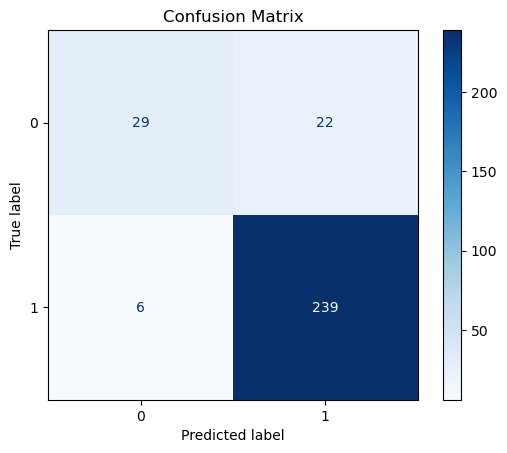

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
to_predict_dataset = group_by_activity([group1A_mean_df, group2A_mean_df], ['Activity'])
# use the above model to predict the backpain for group2B

X_to_predict = to_predict_dataset.drop(columns=['Group', 'Backpain'])

y_true = to_predict_dataset['Backpain']

y_pred = grid_search_knn.predict(X_to_predict)

accuracy_pred = accuracy_score(y_true, y_pred)


# Print classification report
print("Classification Report:")
print("accuracy:", accuracy_pred)
print(classification_report(y_true, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [52]:


import test


a1 = flatternData(sample_video['positions'], openpose_joint_mapping)
a1.insert(0, 'Group', "gr1a")
a1.insert(1, 'Activity', "CTK")
a2 = flatternData(sample_video['positions'], openpose_joint_mapping)
a2.insert(0, 'Group', "gr1a")
a2.insert(1, 'Activity', "RTK")

testdf = pd.concat([a1, a2], ignore_index=True)
df_encoded = pd.get_dummies(testdf, columns=['Activity'])
df_encoded

,Group,1.0_Nose_x,1.0_Nose_y,1.0_Nose_z,1.0_Left_eye_x,1.0_Left_eye_y,1.0_Left_eye_z,2.0_Nose_x,2.0_Nose_y,2.0_Nose_z,...,3.0_Left_eye_y,3.0_Left_eye_z,4.0_Nose_x,4.0_Nose_y,4.0_Nose_z,4.0_Left_eye_x,4.0_Left_eye_y,4.0_Left_eye_z,Activity_CTK,Activity_RTK
0,gr1a,1,1,1,1,1,1,2,2,2,...,3,3,4,4,4,4,4,4,True,False
1,gr1a,1,1,1,1,1,1,2,2,2,...,3,3,4,4,4,4,4,4,False,True
